In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding,GlobalMaxPooling1D, SpatialDropout1D,GRU

We`ll perform sentiment analysis on a corpus of movie reviews. We’re asked to label each phrase on a scale of zero to four. The sentiment corresponding to each of the labels are:


0: negative

1: somewhat negative

2: neutral

3: somewhat positive

4: positive


In [19]:
df_train = pd.read_csv('/content/train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [20]:
df_test = pd.read_csv('/content/test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [21]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [22]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


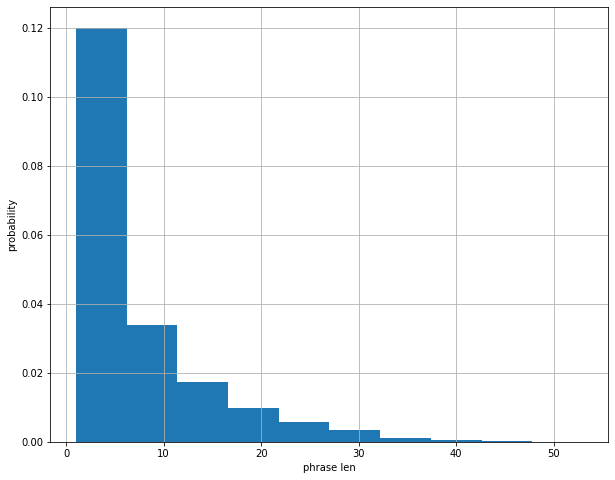

In [23]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid()

In [24]:
y_train = df_train['Sentiment']

In [25]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [26]:
batch_size = 512
epochs = 8

In [27]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(GRU(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [28]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 2048
)

Epoch 1/8
69/69 [==============================] - 542s 8s/step - loss: 1.2063 - accuracy: 0.5220 - val_loss: 1.1432 - val_accuracy: 0.5351
Epoch 2/8
69/69 [==============================] - 555s 8s/step - loss: 0.9317 - accuracy: 0.6286 - val_loss: 1.0272 - val_accuracy: 0.5928
Epoch 3/8
69/69 [==============================] - 536s 8s/step - loss: 0.8374 - accuracy: 0.6641 - val_loss: 1.0147 - val_accuracy: 0.6025
Epoch 4/8
69/69 [==============================] - 530s 8s/step - loss: 0.7993 - accuracy: 0.6782 - val_loss: 1.0100 - val_accuracy: 0.6016
Epoch 5/8
69/69 [==============================] - 542s 8s/step - loss: 0.7704 - accuracy: 0.6887 - val_loss: 1.0315 - val_accuracy: 0.6021
Epoch 6/8
69/69 [==============================] - 547s 8s/step - loss: 0.7492 - accuracy: 0.6951 - val_loss: 1.0442 - val_accuracy: 0.5997
Epoch 7/8
69/69 [==============================] - 530s 8s/step - loss: 0.7329 - accuracy: 0.7021 - val_loss: 1.0519 - val_accuracy: 0.6013
Epoch 8/8
69/69 [===

In [ ]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()